In [1]:
# IMPORTING THE REQUIRED LIBRARIES:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())


1.8.1
3.6.10


In [2]:
torch.cuda.get_device_name(1)

'TITAN X (Pascal)'

In [3]:
# LOADING DATA: 1000 MOST COMMON ENGLISH WORDS

top_1000_words = pd.read_csv('top_1000.txt', delimiter = '\t', header = None)

words = []
sample_length = len(top_1000_words)

for i in range(sample_length):
    words.append(top_1000_words.loc[i][0])
    

In [4]:
# DEFINING TRAINING, VALIDATION AND TEST SETS

train_set = words[0:800] * 32
val_set = words[800:900] 
test_set = words[900:1000] 

MAX_LENGTH = max(len(list(word)) for word in train_set) # length of the longest word within our sample

print(MAX_LENGTH)
print(test_set)

11
['oxygen', 'sugar', 'death', 'pretty', 'skill', 'women', 'season', 'solution', 'magnet', 'silver', 'thank', 'branch', 'match', 'suffix', 'especially', 'fig', 'afraid', 'huge', 'sister', 'steel', 'discuss', 'forward', 'similar', 'guide', 'experience', 'score', 'apple', 'bought', 'led', 'pitch', 'coat', 'mass', 'card', 'band', 'rope', 'slip', 'win', 'dream', 'evening', 'condition', 'feed', 'tool', 'total', 'basic', 'smell', 'valley', 'nor', 'double', 'seat', 'arrive', 'master', 'track', 'parent', 'shore', 'division', 'sheet', 'substance', 'favor', 'connect', 'post', 'spend', 'chord', 'fat', 'glad', 'original', 'share', 'station', 'dad', 'bread', 'charge', 'proper', 'bar', 'offer', 'segment', 'slave', 'duck', 'instant', 'market', 'degree', 'populate', 'chick', 'dear', 'enemy', 'reply', 'drink', 'occur', 'support', 'speech', 'nature', 'range', 'steam', 'motion', 'path', 'liquid', 'log', 'meant', 'quotient', 'teeth', 'shell', 'neck']


In [5]:
# ONE HOT ENCODING OF THE ALPHABET (+ START, END & PAD)

letters = ['START', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'END']

PAD = torch.zeros(1, 1, 28)

def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)

print(PAD)
print(letter_to_vector('START'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]]])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [7]:
# GETTING PATCH TENSOR FOR EACH WORD (PATCH, COLOR CHANNEL, HEIGHT, WIDTH)

def patch_gen(word, n_patches, patch_height, patch_width, stepsize):
    
    image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
        thickness = 1, lineType = cv2.LINE_AA)
    image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
    patches_tensor = torch.empty(n_patches, color_channels, patch_height, patch_width)
    
    for p in range(n_patches):
        
        patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
        #patch = skimage.util.random_noise(patch, mode='s&p') # we set some random noise to the image
        #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
        patch = 1. - patch # it will work better if we have white text over black background
        patch = patch.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        patch = patch.type(torch.FloatTensor) # conversion to float
        patch = patch.cuda(1) # set to cuda
        patches_tensor[p, 0, :, :] = patch
        patches_tensor = patches_tensor.cuda(1)
        
    return patches_tensor

In [8]:
# SETTING IMAGE AND SLIDING WINDOW (PATCH) PARAMETERS

height = 48
width = 192
patch_height = 48
patch_width = 10
stepsize = 2
color_channels = 1
n_patches = int((width - patch_width)/stepsize + 1) 

In [9]:
# GETTING TUPLE (TENSOR WITH PATCHES, LABEL) FOR EACH WORD OF A GIVEN SET:

def complete_set(which_set):
    
    complete_set = []
    
    for word in which_set:
        
        complete_set.append((patch_gen(word, n_patches, patch_height, patch_width, stepsize), word))
        
    return complete_set

In [10]:
# TUPLE OF (RANK-4 TENSOR [PATCH, CHANNEL, HEIGHT, WIDTH], LABEL) FOR EVERY WORD IN EVERY SET

comp_train_set = complete_set(which_set = train_set)
comp_val_set = complete_set(which_set = val_set)
comp_test_set = complete_set(which_set = test_set)

In [11]:
# LOADING DATA AND SETS IN BATCHES

torch.manual_seed(123)

batch_size = 16

train_loader = DataLoader(comp_train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(comp_val_set, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(comp_test_set, batch_size = batch_size, shuffle = False)


for image, label in train_loader:
    break
    
image_cnn = image.view(-1, color_channels, patch_height, patch_width)   
print(image.shape)
print(image_cnn.shape)
print(label)

torch.Size([16, 92, 1, 48, 10])
torch.Size([1472, 1, 48, 10])
('war', 'sleep', 'stick', 'paper', 'page', 'floor', 'not', 'special', 'hunt', 'food', 'measure', 'equal', 'soon', 'ride', 'tall', 'stone')


In [12]:
# GETTING ONE HOT TENSOR OF THE TARGET WORD

    # one hot tensor of the input batch of words for the Decoder:
    # 1 dim for position within batch, 1 dim for position of the letter in the fixed sequence (MAX_LENGTH + START + END),
    # 1 final dim specifying letter (output_size = 26 + START and END tokens)
    # torch.zeros() ensures that we always have PAD token vectors in case our target word is not MAX_LENGTH long
    # WARNING: only works if label contains 2 words or more (it is OK as long as we are doing batching)
    
def get_one_hot_target(label, batch, seq_len, output_size):
    
    one_hot_target = torch.zeros(batch, seq_len, output_size) 

    for j in range(batch): # for each word of the batch

        length = len(list(label[j])) # we compute the number of letters

        one_hot_target[j, 0, :] = letter_to_vector('START') # the first letter of every word will always be the START

        for k in range(0, length): # now for each letter of the target word

            target_letter = list(label[j])[k] # picks the 'k' target letter 
            one_hot_target[j, k + 1, :] = letter_to_vector(target_letter) # adds that one hot target letter to our global tensor

        one_hot_target[j, length + 1, :] = letter_to_vector('END') # we put END after the last letter of the word

    return one_hot_target     

In [13]:
# EARLY STOPPING FUNCTION

# If our validation loss has not improved for a certain patience 'n', we stop the training

def Early_Stopping(n, losses):
    previous_losses = torch.tensor(losses[-(n + 1):-1]).cuda(1) # n previous values of the validation loss
    last_loss = losses[-1] # last value of the validation loss
    comparison = last_loss > previous_losses # n-length boolean vector
    comparison = all(comparison) # = True if all previous values of the validation loss are smaller than the last one
    
    return comparison

In [14]:
# DEFINING MODEL AND ARCHITECTURE

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [15]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden, batch, seq_len):
        
        output = input.view(batch, seq_len, input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self, batch):
        return (torch.zeros(1, batch, self.hidden_size, device=device),
                torch.zeros(1, batch, self.hidden_size, device=device))

In [16]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2) 
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden, batch, seq_len):
        
        output = input.view(batch, seq_len, output_size)
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch):
        return (torch.zeros(1, batch, self.hidden_size, device=device),
               torch.zeros(1, batch, self.hidden_size, device=device))

In [17]:
torch.manual_seed(123)

input_size = 1024
hidden_size = 256
output_size = 28

CNN_model = ConvolutionalNetwork().cuda(1)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.001)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda(1)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda(1)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [18]:
# TRAINING THE MODEL:

import time
start_time = time.time()

# Tensorboard real time visualisation:

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

epochs = 5000

patience = 100
min_loss_val = 5 # huge initial value for the minimum validation loss

train_losses = []
val_losses = []

torch.manual_seed(123)

for i in range(epochs):
    
    for b, (image, label) in enumerate(train_loader):
        
        b += 1
        train_batch = len(label) # last batch may be of smaller, different size

        encoder_hidden = Encoder_model.initHidden(batch = train_batch)

        image_cnn = image.view(-1, color_channels, patch_height, patch_width).cuda(1)
        encoder_input = CNN_model(image_cnn)
        _, encoder_hidden = Encoder_model(encoder_input, encoder_hidden, batch = train_batch, seq_len = n_patches)

        decoder_hidden = encoder_hidden
        decoder_input = get_one_hot_target(label=label, batch = train_batch, seq_len = MAX_LENGTH + 2,
                                          output_size = output_size).cuda(1)
        decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden,
                                                       batch = train_batch, seq_len = MAX_LENGTH + 2)

        output_indices = torch.tensor(list(range(0, MAX_LENGTH + 1))).cuda(1) # removing last token from the output
        decoder_output = torch.index_select(decoder_output, dim = 1, index = output_indices)

        ground_truth = torch.argmax(decoder_input, dim = 2)
        target_indices = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove SOS_token from the input
        ground_truth = torch.index_select(ground_truth, dim = 1, index = target_indices)

        loss = 0
        
        for j in range(train_batch):
            
            loss += criterion(decoder_output[j], ground_truth[j])   
            
        loss = loss/train_batch
        
        
        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        
        loss.backward()
        
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
    
    
    with torch.no_grad():
        
        for v, (image_val, label_val) in enumerate(val_loader):
        
            v += 1
            val_batch = len(label_val)
            
            encoder_hidden_val = Encoder_model.initHidden(batch = val_batch)

            image_cnn_val = image_val.view(-1, color_channels, patch_height, patch_width).cuda(1)
            encoder_input_val = CNN_model(image_cnn_val)
            _, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val, batch = val_batch, seq_len = n_patches)

            decoder_hidden_val = encoder_hidden_val
            decoder_input_val = get_one_hot_target(label=label_val, batch = val_batch, seq_len = MAX_LENGTH + 2,
                                                  output_size = output_size).cuda(1)
            decoder_output_val, decoder_hidden_val = Decoder_model(decoder_input_val, decoder_hidden_val,
                                                                  batch = val_batch, seq_len = MAX_LENGTH + 2)
            
            output_indices_val = torch.tensor(list(range(0, MAX_LENGTH + 1))).cuda(1) # remove EOS_token from the output
            decoder_output_val = torch.index_select(decoder_output_val, dim = 1, index = output_indices_val)

            ground_truth_val = torch.argmax(decoder_input_val, dim = 2)
            target_indices_val = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove SOS_token from the input
            ground_truth_val = torch.index_select(ground_truth_val, dim = 1, index = target_indices_val)
            
            loss_val = 0
            
            for j in range(val_batch):
                
                loss_val += criterion(decoder_output_val[j], ground_truth_val[j])
            
            loss_val = loss_val/val_batch
        
        
    train_losses.append(loss)
    val_losses.append(loss_val)
    
    # Sending losses to Tensorboard: 
    writer.add_scalar('Loss/train', loss, i)
    writer.add_scalar('Loss/validation', loss_val, i)
    
    patience -= 1 # updating patience
    
    if patience == 0: # Early Stopping
        
        break
    
    else:
        
        if loss_val < min_loss_val: # condition to save the best model

            min_loss_val = loss_val

            patience = 100

            # Saving best model:

            torch.save(CNN_model.state_dict(), 'CNN_model_1000_words_TF.pt')
            torch.save(Encoder_model.state_dict(), 'Encoder_model_1000_words_TF.pt')
            torch.save(Decoder_model.state_dict(), 'Decoder_model_1000_words_TF.pt')

    
    # if (i > patience) & (Early_Stopping(patience, val_losses) == True): # Early Stopping
        
    #    break

        
    print(f'Epoch: {i}')
    
print(f'Duration: {(time.time() - start_time)/60} minutes')    
print(train_losses)
print(val_losses)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

[tensor(2.1420, device='cuda:1'), tensor(2.0116, device='cuda:1'), tensor(1.9238, device='cuda:1'), tensor(1.8392, device='cuda:1'), tensor(1.7457, device='cuda:1'), tensor(1.6855, device='cuda:1'), tensor(1.6418, device='cuda:1'), tensor(1.5993, device='cuda:1'), tensor(1.5755, device='cuda:1'), tensor(1.5641, device='cuda:1'), tensor(1.5046, device='cuda:1'), tensor(1.4807, device='cuda:1'), tensor(1.4609, device='cuda:1'), tensor(1.4697, device='cuda:1'), tensor(1.4100, device='cuda:1'), tensor(1.3811, device='cuda:1'), tensor(1.3608, device='cuda:1'), tensor(1.3397, device='cuda:1'), tensor(1.3136, device='cuda:1'), tensor(1.2972, device='cuda:1'), tensor(1.2801, device='cuda:1'), tensor(1.2611, device='cuda:1'), tensor(1.2468, device='cuda:1'), tensor(1.2320, device='cuda:1'), tensor(1.2171, device='cuda:1'), tensor(1.2127, device='cuda:1'), tensor(1.2024, device='cuda:1'), tensor(1.1848, device='cuda:1'), tensor(1.1885, device='cuda:1'), tensor(1.1790, device='cuda:1'), tensor(1.

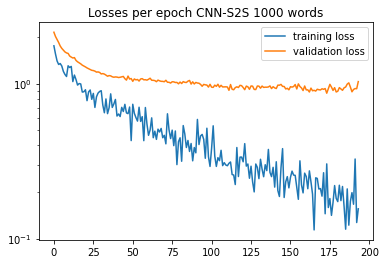

In [20]:
# Plotting results

plt.yscale("log")
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Losses per epoch CNN-S2S 1000 words')
plt.legend();
#plt.savefig('8 words training losses lr=0,001, bs=2')

In [43]:
CNN_model.load_state_dict(torch.load('CNN_model_1000_words_TF.pt'))
CNN_model.eval()

Encoder_model.load_state_dict(torch.load('Encoder_model_1000_words_TF.pt'))
Encoder_model.eval()

Decoder_model.load_state_dict(torch.load('Decoder_model_1000_words_TF.pt'))
Decoder_model.eval()

DecoderRNN(
  (lstm): LSTM(28, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=28, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [67]:
with torch.no_grad():
        
    for t, (image_test, label_test) in enumerate(test_loader):

        t += 1
        test_batch = len(label_test)
        
        encoder_hidden_test = Encoder_model.initHidden(batch = test_batch)
        
        image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda(1)
        encoder_input_test = CNN_model(image_cnn_test)
        _, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test, batch=test_batch,
                                                                 seq_len=n_patches)
        
        for j in range(test_batch):
           
            decoder_input_test = letter_to_vector('SOS_token').cuda(1) # We initialize the first Decoder input as the SOS token
            
            decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                   encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the patch 
            # This would be the first hidden state of the Decoder for image/word (j)

            for d in range(MAX_LENGTH):
                
                decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test,
                                                                        batch=1, seq_len=1)

                if d == 0:
                    
                    output_word = decoder_output_test
                    
                else:
                    
                    output_word = torch.cat((output_word, decoder_output_test), dim = 1).cuda(1)
                
                
                if  torch.equal(torch.argmax(decoder_output_test, dim = 2), 
                                 torch.argmax(letter_to_vector('END').cuda(1), dim = 2)):
                    break
                
            output_word = torch.argmax(output_word, dim = 2)
            print(output_word)   
           # if j == 0:
                
            #    total_output_word = output_word
                
            #else:
                
             #   total_output_word = torch.cat((total_output_word, output_word), dim = 1)
           
    #print(total_output_word)


#for j in range(batch_size):
    
 #   model_word = []
    
  #  for i in range(total_output_word[j].numel()):
        
   #     if letters[total_output_word[j][i]] == 'SOS_token':
      #      break
            
    #    model_word.append(letters[total_output_word[j][i]])
        
        
    #model_word = ''.join(model_word)    
    #print(model_word)

    

tensor([[ 5,  5, 14, 14, 14, 27]], device='cuda:1')
tensor([[19, 18,  1, 18, 18, 27]], device='cuda:1')
tensor([[ 1,  1, 20, 20,  8, 27]], device='cuda:1')
tensor([[ 5,  5, 20, 20, 20, 18, 27]], device='cuda:1')
tensor([[12, 12, 12, 12, 12, 27]], device='cuda:1')
tensor([[13, 15,  5, 13, 14, 27]], device='cuda:1')
tensor([[19,  1, 19, 19, 19, 19, 27]], device='cuda:1')
tensor([[19, 15, 21, 21, 21,  9,  9, 12, 27]], device='cuda:1')
tensor([[13,  5,  5,  5, 14, 20, 27]], device='cuda:1')
tensor([[19,  9, 12, 12,  5,  5, 27]], device='cuda:1')
tensor([[20,  8,  1,  1, 11, 27]], device='cuda:1')
tensor([[ 2, 18,  1,  1,  1,  8, 27]], device='cuda:1')
tensor([[20,  1,  1,  3,  8, 27]], device='cuda:1')
tensor([[19, 21,  9,  9, 21, 21, 27]], device='cuda:1')
tensor([[16,  5, 16, 16, 16, 16,  5, 12, 12, 27]], device='cuda:1')
tensor([[ 7,  9,  7, 27]], device='cuda:1')
tensor([[ 6, 18,  1,  9,  9,  4, 27]], device='cuda:1')
tensor([[ 8, 21,  7,  5, 27]], device='cuda:1')
tensor([[19,  9, 19,

In [12]:
torch.manual_seed(101)
c = nn.LogSoftmax(dim=2)
a = torch.randn(1,2,3)
print(c(a))
print(a)

tensor([[[-1.7393, -1.1640, -0.6692],
         [-0.6714, -3.1625, -0.8059]]])
tensor([[[-1.3905, -0.8152, -0.3204],
         [ 0.7377, -1.7534,  0.6033]]])


In [11]:
np.log((np.exp(-1.3905))/(np.exp(-1.3905) + np.exp(-0.8152) + np.exp(-0.3204)))

-1.7392961570497802

In [141]:
np.log((np.exp(-1.3905))/(np.exp(-1.3905) + np.exp(0.7377)))

-2.240681356437162

In [23]:
a = torch.ones(28).cuda(1)
c = torch.argmax(a, dim = 0)
print(a)
print(c)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:1')
tensor(0, device='cuda:1')


In [23]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

SyntaxError: can't assign to operator (<ipython-input-23-214c4d391130>, line 4)

In [21]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
x = range(100)
for i in x:
    writer.add_scalar('y=2x', i * 2, i)
writer.close()

In [20]:
a = torch.tensor([1,2,3])
b = torch.tensor([0.5])
c = b<a
x = all(c)
print(x)

True


In [35]:
a = torch.tensor(train_losses[-5:-1]).cuda(1)
b = train_losses[-1]
c = b<a
x = all(c)
print(x)
print(a)
print(b)

False
tensor([0.3553, 0.2992, 0.3441, 0.3689], device='cuda:1')
tensor(0.5201, device='cuda:1', grad_fn=<DivBackward0>)


In [42]:
Early_Stopping(5, train_losses, loss)

True

In [ ]:
# activar pytorch_estoril (environment) en la terminal y ejecutar tensorboard --host 0.0.0.0 --logdir ./runs
# Tensorboard se ejecutará en un cierto puerto y nos dará el enlace. Habrá que sustituir la IP 0.0.0.0 por la del equipo
# en remoto en la que esté corriendo en el caso de Estoril 212.128.3.86:

In [133]:
a = torch.zeros(1,1,28)
print(a.shape)
a_2 = torch.argmax(a, 2)
print(a_2)
print(a)

torch.Size([1, 1, 28])
tensor([[0]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]]])


In [156]:
a = torch.tensor([[28]])
print(a.shape)
print(a)

torch.Size([1, 1])
tensor([[28]])


In [161]:
print(letter_to_vector('EOS_token').view(1,28))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [90]:
torch.manual_seed(123)
t = torch.rand(6, 4)
print(t)
t = t.view(2,3,4)
print(t)

tensor([[0.2961, 0.5166, 0.2517, 0.6886],
        [0.0740, 0.8665, 0.1366, 0.1025],
        [0.1841, 0.7264, 0.3153, 0.6871],
        [0.0756, 0.1966, 0.3164, 0.4017],
        [0.1186, 0.8274, 0.3821, 0.6605],
        [0.8536, 0.5932, 0.6367, 0.9826]])
tensor([[[0.2961, 0.5166, 0.2517, 0.6886],
         [0.0740, 0.8665, 0.1366, 0.1025],
         [0.1841, 0.7264, 0.3153, 0.6871]],

        [[0.0756, 0.1966, 0.3164, 0.4017],
         [0.1186, 0.8274, 0.3821, 0.6605],
         [0.8536, 0.5932, 0.6367, 0.9826]]])


In [33]:
torch.equal(torch.argmax(letter_to_vector('END'), dim = 2), torch.argmax(letter_to_vector('START'), dim = 2))

False

2
1
